In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
import sklearn.datasets

def prepare_swissroll_data(BATCH_SIZE=1000):
    ''' This is derived from https://github.com/lukovnikov/improved_wgan_training/blob/master/gan_toy.py
         Copyright (c) 2017 Ishaan Gulrajani
         Released under the MIT license
         https://github.com/lukovnikov/improved_wgan_training/blob/master/LICENSE '''
    data = sklearn.datasets.make_swiss_roll(
                    n_samples=BATCH_SIZE,
                    noise=0.25
                )[0]
    data = data.astype('float32')[:, [0, 2]]
    data /= 7.5 # stdev plus a little
    return data

def plot_2d_data(X, title=None, ax=None, G=None, D=None):
    if ax is None:
        fig = plt.figure(figsize=(5,5+2*(D is not None)))
        ax = fig.add_subplot(1,1,1)
    if title is not None:
        ax.set_title(title)
    if D is not None:
        mesh=100
        mu_x = np.linspace(-1.6, 2.0, mesh)
        mu_y = np.linspace(-1.7, 2.1, mesh)
        mu_x, mu_y = np.meshgrid(mu_x, mu_y)
        mu_xy = np.concatenate([mu_x.reshape(mesh,mesh,1), mu_y.reshape(mesh,mesh,1)], axis=2).astype(np.float32)
        #print(mu_xy.shape)
        out = tf.reshape(D(mu_xy.reshape(mesh**2, 2)), shape=(mesh, mesh))
        mappable = ax.contour(mu_x, mu_y, out, 20, alpha=0.9, cmap='Greens')
        cbar = plt.colorbar(mappable, ax=ax, orientation='horizontal')
        cbar.set_label('D(x)', rotation=0, color='green', fontsize=20)
        
    ax.set_xlim(-1.6, 2.0); ax.set_ylim(-1.7, 2.1)
    ax.scatter(X[:,0], X[:,1], alpha=0.5)
    
    if G is not None:
        sample_size=1000
        x_fake = G.generate(sample_size)
        ax.scatter(x_fake[:,0], x_fake[:,1], marker='.', alpha=0.5, color='red', label='G(z)')
        lgd = ax.legend(fontsize=20, loc='upper left')
        for text in lgd.get_texts():
            text.set_color("red")

def show(X, titles=None, horizontal=False):
    batch_size = X.shape[0]
    size = ceil(batch_size**(1/2))
    if horizontal:
        fig = plt.figure(figsize=(batch_size, size))
    else:
        fig = plt.figure(figsize=(size, size))
    for img_label in range(batch_size):
        if horizontal:
            ax = fig.add_subplot(1, batch_size, img_label+1)
        else:
            ax = fig.add_subplot(size, size, img_label+1)
        ax.axis("off")
        try:
            ax.imshow(X[img_label])
        except TypeError:
            ax.imshow(X[img_label,:,:,0], cmap='gray')
        if titles is not None:
            ax.set_title(titles[img_label])
    plt.show()

## 8-2. 敵対的生成ネットワーク
次に紹介するのは **敵対的生成ネットワーク(Generative Adversarial Network, GAN)** と呼ばれるものです。元論文は [arXiv:1406.2661](https://arxiv.org/abs/1406.2661) です。これは2つのネットワークを戦わせて上手い画像を生成させるような方法です。

$$
\text{Generator } G : Z \to X
\\
\text{Discriminator }D : X \to \mathbb{R}
$$

という２つのネットワークを用意します。ここでは $D$ は実数値を返すものとします$^※$。
> $^※$元論文では確率値となっていますが、$\tilde{D}(x) = \sigma_\text{sigmoid}(D(x))$ とチルダ付きの D を定義すれば確率値になります。このように D の出力を実数値にしておくと元論文以外のGANの実装が少し楽になる気がします。

Generator は VAEのときの decoder をδ関数

$$
p_\theta(x|z)=
\delta(x - G_\theta(z))
$$

と取ったものになります。この設定のもとで、$G,D$を「戦わせ」ることで、

$$
p_\theta(x)=
\int dz  \ \delta(x - G_\theta(z)) p(z)
$$

がデータ生成確率 $p(x)$ に近づくようにします。それぞれ以下のような機能を持ったモデルとして実装します：

In [3]:
class Generator(tf.keras.Model):
    def __init__(self, dim_Z):
        self.dim_Z = dim_Z
        self.pz = tf.random.normal
    def call(self, z):
        x = None
        return x
    def generate(self, sample_size):
        z = self.pz(shape=(sample_size, self.dim_Z))
        return self(z)
    
class Discriminator(tf.keras.Model):
    def __init__(self):
        pass
    def call(self, x):
        out = None
        return out # (batch_size, 1) 出力はスカラー値(確率値)

#### 訓練の方法
それぞれのネットワークのパラメータを
* $G$については $\theta$ とよび、ネットワークを$G_\theta$
* $D$については $\varphi$ とよび、ネットワークを$D_\varphi$

と呼ぶことにします。これまでの手法と異なる点は、$G_\theta$ と $D_\varphi$ について、それぞれで異なる目的関数 $V_G, V_D$ を考えることです。ここでは

$$
\left. \begin{array}{lll}
V_G(G, D) &=  \langle \log (1+e^{-D(G(z))})\rangle_{z \sim p_z}
\\
V_D(G, D) 
&= \langle \log (1+e^{-D(x)})\rangle_{x \sim p} &+ \langle \log (1+e^{+D(G(z))})\rangle_{z \sim p_z}
\end{array} \right.
$$

を考えます。後者の$V_D$を小さくすることは本物(1項目)と偽物(2項目)を分類する $D$ の探索になりますが、前者の $V_G$ を $G$ について小さくするのは、その分類を「だます」ようにする働きがあります。そのような構造を持った関数であれば上のような定義でなくとも良いです。

実際の計算では厳密な期待値は取れないので、サンプル平均でこれをまかないます。以下ではそれぞれ
* `d_fake` = $D(G(z))$ 
* `d_real` = $D(x)$

とした実装です。`softplus`$(d) = \log(1+e^{d})$ です。



In [4]:
from tensorflow.keras.activations import softplus

def gloss_softplus(d_fake):
    return tf.reduce_mean(softplus(-d_fake))

def dloss_softplus(d_real, d_fake):
    return tf.reduce_mean(softplus(-d_real) + softplus(d_fake))

$G_\theta, D_\varphi$ のパラメータは以下のように別々の勾配更新を交代交代に行います。これは「だます方向の訓練(G)」と「偽物を分類する方向の訓練(D)」からなるダイナミクスです：

$$
\left. \begin{array}{ll}
\theta \leftarrow \theta - \eta_G \nabla_\theta V_G(G_\theta, D_\varphi), & \text{:fooling}
\\
\varphi \leftarrow \varphi - \eta_D \nabla_\varphi V_D(G_\theta, D_\varphi), & \text{:classifying}
\end{array} \right.
$$

In [5]:
def batch_step(X, G, D, opt_G, opt_D, gloss=gloss_softplus, dloss=dloss_softplus):
    sample_size = X.shape[0]
    # D update :classifying
    with tf.GradientTape() as tape:
        loss_D = dloss(D(X), D(G.generate(sample_size)))
    grads_D = tape.gradient(loss_D, D.trainable_variables)
    opt_D.apply_gradients(zip(grads_D, D.trainable_variables))
    # G update :fooling
    with tf.GradientTape() as tape:
        loss_G = gloss(D(G.generate(sample_size)))
    grads_G = tape.gradient(loss_G, G.trainable_variables)
    opt_G.apply_gradients(zip(grads_G, G.trainable_variables))
    return loss_D, loss_G

### 2次元でGAN
以下のように $X$ を実2次元空間として、その上にスイスロール状に分布したデータを教師なしデータとして、GANを訓練してみましょう。

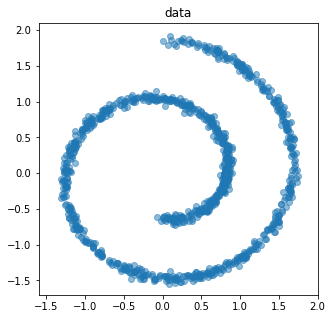

In [6]:
X_2d = prepare_swissroll_data() # 出力はnumpy.array
plot_2d_data(X_2d, title='data'); plt.show()

#### Generator
3回`Dense`でつないだ単純なものを作ってみました。また、$p_z$ は $[-1,1]$ の一様分布にしました。

In [7]:
class Generator_2d(tf.keras.Model):
    def __init__(self, dim_Z=256, dim_feature=128):
        super(Generator_2d, self).__init__()
        initializer = tf.initializers.he_normal()
        self.l1 = tf.keras.layers.Dense(dim_feature, kernel_initializer=initializer)
        self.l2 = tf.keras.layers.Dense(dim_feature, kernel_initializer=initializer)
        self.l3 = tf.keras.layers.Dense(2, kernel_initializer=initializer)
        self.dim_Z = dim_Z

    def call(self, z):
        h = tf.nn.leaky_relu(self.l1(z))
        h = tf.nn.leaky_relu(self.l2(h))
        h = self.l3(h)
        return h
    
    def generate(self, sample_size):
        z = tf.random.uniform(shape=(sample_size, self.dim_Z), minval=-1, maxval=1)
        return self(z)

#### Discriminator
こちらも3回`Dense`です。

In [8]:
class Discriminator_2d(tf.keras.Model):
    def __init__(self, dim_feature=128):
        super(Discriminator_2d, self).__init__()
        initializer = tf.initializers.he_normal()
        self.l1 = tf.keras.layers.Dense(dim_feature, kernel_initializer=initializer)
        self.l2 = tf.keras.layers.Dense(dim_feature, kernel_initializer=initializer)
        self.l3 = tf.keras.layers.Dense(1, kernel_initializer=initializer)

    def call(self, x):
        h = tf.nn.leaky_relu(self.l1(x))
        h = tf.nn.leaky_relu(self.l2(h))
        h = self.l3(h)
        return h

#### Training
訓練中のテストは実際に2次元にプロットすることにします。

In [9]:
def train_2d(G, D, X_2d, batch_size, epochs=5):
    tf_batch_step = tf.function(batch_step)
    opt_G = tf.keras.optimizers.Adam(1e-3)
    opt_D = tf.keras.optimizers.Adam(1e-3)
    Data = tf.data.Dataset.from_tensor_slices(X_2d)
    fig = plt.figure(figsize=(5*6,7))
    plotlabel = 1
    for epoch in range(epochs+1):
        if epoch%(epochs//5)==0:
            #test
            ax = fig.add_subplot(1,6,plotlabel)
            plot_2d_data(X_2d, title="{}-epoch".format(epoch), ax=ax, D=D, G=G)
            plotlabel += 1
        batch = Data.shuffle(len(X_2d)).batch(batch_size, drop_remainder=True)
        for X in batch:
            loss_D, loss_G = tf_batch_step(X, G, D, opt_G, opt_D)
    plt.show()
    return G, D

以下の訓練は CPU でもそれなりに早く完了できます。テストでは
* データ点は青い大きな点
* $G$が作り出したフェイク点は赤い小さい点
* $D$が本物と判別しているところは濃い緑の等高線

として表示しています。

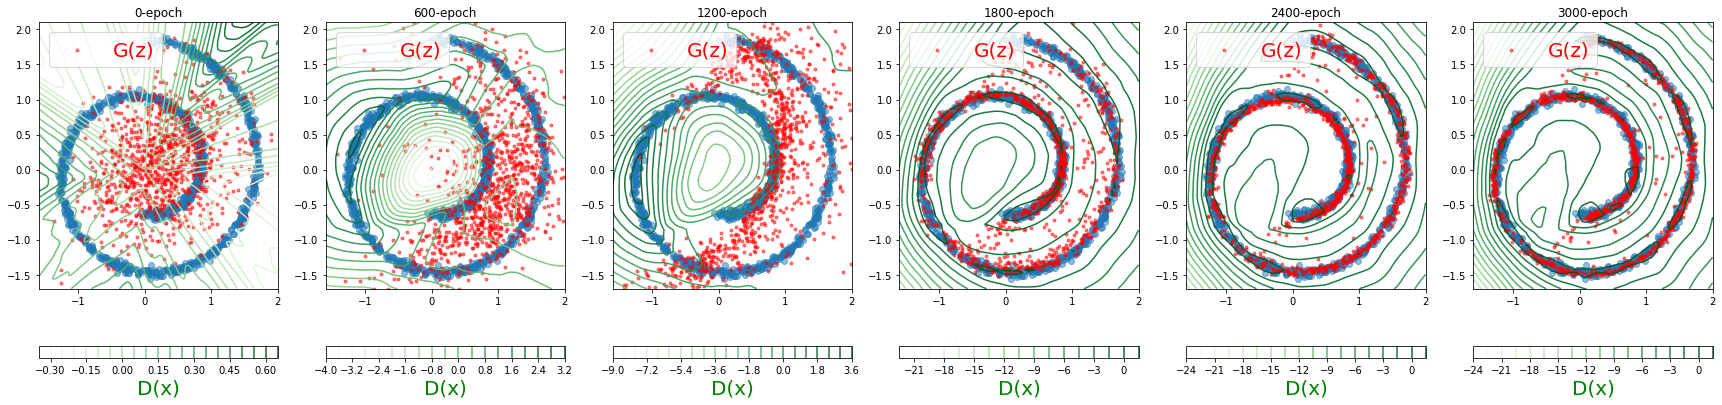

CPU times: user 2min 25s, sys: 8.78 s, total: 2min 34s
Wall time: 1min 4s


In [11]:
%%time
G = Generator_2d(dim_Z=128)
D = Discriminator_2d()
train_2d(G, D, X_2d, batch_size=256, epochs=3000)

こんなふうに、$D$ と $G$ がせめぎ合って、うまくいけば $G(z)$ の集まりがデータを真似られるようになります。また、最終的な$D$の等高線がデータ点周辺で値が大きくなっていることから、$-D$ はデータ空間 $X$ 上で実際にデータのある点で最小値を持つエネルギー関数のようにも感じられます。実際そのような提案[arXiv:1609.03126](https://arxiv.org/abs/1609.03126)もあります。

### MNISTでGAN
次に MNIST でラベル情報を捨てた教師なし学習をGANでやってみましょう。ネットワークの構成などのパラメータ設定はtensorflowのチュートリアルを参考にしています。まず MNIST をピクセル値 $\in [-1,1]$ にして読み込みます。

In [12]:
mnist = tf.keras.datasets.mnist
(X, Y), (X_test, Y_test) = mnist.load_data()
X, X_test = 2*(X/255 -1/2).astype(np.float32), 2*(X_test/255-1/2).astype(np.float32)
X_train = tf.reshape(tf.concat([X, X_test], axis = 0), shape=(70000, 28, 28, 1))

#### Generator
転置畳み込み+バッチ正規化です。GANでバッチ正規化を使うと良いというのはDCGANと呼ばれるモデル([arXiv:1511.06434](https://arxiv.org/abs/1511.06434))で指摘されましたが、バッチ正規化があったほうが良いかどうかはニューラルネットの構造に依存する問題だと思います。注意なのは、バッチ正規化を使う場合、内部に保存した $\mu, \sigma$ を使うのか、バッチの統計の $\mu, \sigma$ を使うのかの問題がありましたが、テストの段階と使い分けられるようにしておかないとハマります。

In [13]:
class Generator_mnist(tf.keras.Model):
    ''' This model definition is derived from the generator model defined in
        https://www.tensorflow.org/tutorials/generative/dcgan
        which is licenced under Apache 2.0 License. '''
    def __init__(self, dim_Z=100):
        super(Generator_mnist, self).__init__()
        self.dense = tf.keras.layers.Dense(7*7*256, use_bias=False)
        self.bn    = tf.keras.layers.BatchNormalization()
        self.dc1   = tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)
        self.bn1   = tf.keras.layers.BatchNormalization()
        self.dc2   = tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)
        self.bn2   = tf.keras.layers.BatchNormalization()
        self.dc3   = tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False)
        self.dim_Z = dim_Z
        self.pz = tf.random.normal
        
    def call(self, z, training=True):
        h = tf.nn.leaky_relu(self.bn(self.dense(z), training=training))
        h = tf.reshape(h, shape=(-1, 7, 7, 256))
        h = tf.nn.leaky_relu(self.bn1(self.dc1(h), training=training))
        h = tf.nn.leaky_relu(self.bn2(self.dc2(h), training=training))
        h = self.dc3(h)
        return tf.keras.activations.tanh(h)
    
    def generate(self, sample_size, training=True):
        z = self.pz(shape=(sample_size, self.dim_Z))
        return self(z, training=training)

#### Discriminator
こちらはDropoutを用いるようです。

In [14]:
class Discriminator_mnist(tf.keras.Model):
    ''' This model definition is derived from the discriminator model defined in
        https://www.tensorflow.org/tutorials/generative/dcgan
        which is licenced under Apache 2.0 License. '''
    def __init__(self):
        super(Discriminator_mnist, self).__init__()
        self.c1 = tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')
        self.dr1= tf.keras.layers.Dropout(0.3)
        self.c2 = tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')
        self.dr2= tf.keras.layers.Dropout(0.3)
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(1)
        
    def call(self, x):
        h = self.dr1(tf.nn.leaky_relu(self.c1(x)))
        h = self.dr2(tf.nn.leaky_relu(self.c2(h)))
        h = self.flatten(h)
        return self.dense(h)

#### Training
今度はテストとして、各epochのはじめにその段階の $G$ で画像生成させてみることにします。

In [15]:
def train_mnist(G, D, X_train, batch_size, epochs):
    tf_batch_step = tf.function(batch_step)
    opt_G = tf.keras.optimizers.Adam(1e-4)
    opt_D = tf.keras.optimizers.Adam(1e-4)
    Data = tf.data.Dataset.from_tensor_slices(X_train)
    for epoch in range(epochs):
        batch = Data.shuffle(70000).batch(batch_size, drop_remainder=True)
        if epoch%1==0 or epoch==(epochs-1):
            # test
            print("{}-epoch".format(epoch))
            X_generated = G.generate(sample_size=9, training=False) # training=False が重要
            show(X_generated)
        for X in batch:
            loss_D, loss_G = tf_batch_step(X, G, D, opt_G, opt_D)
    return G, D

GPU必須です：

3-epoch


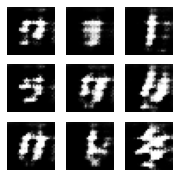

20-epoch


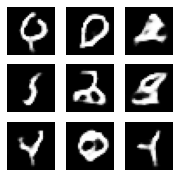

49-epoch


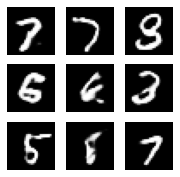

CPU times: user 5min 29s, sys: 1min 15s, total: 6min 44s
Wall time: 28min 32s


In [17]:
%%time
G = Generator_mnist()
D = Discriminator_mnist()
train_mnist(G, D, X_train, batch_size=256, epochs=50)

#### 画像の「ホモトピー」
訓練後、潜在ベクトル二点の間をinterpolate

$$
x(t) = G\big( z(t) \big), \quad z(t):z_1 \to z_2
$$

すると、生成画像がなめらかにつながる様子が確認できます：

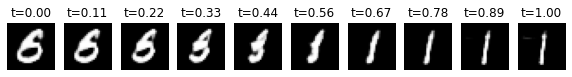

In [18]:
Z1 = tf.random.normal(shape=(1, G.dim_Z))
Z2 = tf.random.normal(shape=(1, G.dim_Z))
for t in np.linspace(0,1,10):
    if t==0:
        X_list = G(Z1, training=False)
    else:
        X_generated = G((1-t)*Z1+t*Z2, training=False)
        X_list = tf.concat([X_list, X_generated], axis=0)
show(X_list, titles=["t={:.02f}".format(t) for t in np.linspace(0,1,10)], horizontal=True)

#### Licence in this subsection
In this notebook, the definitions of

* function: `prepare_swissroll_data`

includes codes derived from
https://github.com/lukovnikov/improved_wgan_training/blob/master/gan_toy.py
which is licenced as follows:
> Copyright (c) 2017 Ishaan Gulrajani <br>
> Released under the MIT license <br>
> https://github.com/lukovnikov/improved_wgan_training/blob/master/LICENSE

In addition, the definitions of

* classes: `Generator_mnist`, `Discriminator_mnist`

include codes derived from
https://www.tensorflow.org/tutorials/generative/dcgan
which is licenced under [Apache 2.0 License](https://www.apache.org/licenses/LICENSE-2.0). For details, see their [Site Policies](https://developers.google.com/terms/site-policies).